In [1]:
# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

## Import the necessary libraries

In [2]:
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import nltk

In [3]:
nltk.download("punkt")
!pip install rouge-score
!pip install pycocoevalcap

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
  Preparing metadata (setup.py) ... - done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=2e4d058e649692cc320d676f27d6ff8e451dd7d2463e9ca4bb66dd5228035156
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.2/426.2 kB 25.8 MB/s eta 0:00:00


In [4]:
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.cider.cider import Cider

# Define function to compute ROUGE score
def compute_rouge(references, candidates):
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    scores = scorer.score(references, candidates)
    return scores['rougeL'].fmeasure

# Define function to compute CIDEr score
def compute_cider(references, candidates):
    scorer = Cider()
    cider_score, _ = scorer.compute_score(references, candidates)
    return cider_score

## Loading the dataset


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=0.5, std=0.5)
])


# Function to load images
def load_images(image_type, num_images):
    images = torch.empty((0, 3, 224, 224), dtype=torch.float32, device=device)
    for i in range(1, num_images):
        img = Image.open(f'/kaggle/input/custom_captions_dataset/{image_type}/{image_type}_{i}.jpg').convert('RGB')
        img_t = transform(img).unsqueeze(0).to(device)
        images = torch.cat((images, img_t), dim=0)
        if (i+1) % 500 == 0:
          print("loaded", i+1, "images")
    return images

# Load images in parallel using GPU
train_images = load_images("train", 5716)
print("train images loaded")

loaded 500 images
loaded 1000 images
loaded 1500 images
loaded 2000 images
loaded 2500 images
loaded 3000 images
loaded 3500 images
loaded 4000 images
loaded 4500 images
loaded 5000 images
loaded 5500 images
train images loaded


In [6]:
# test_cap = pd.read_csv('/kaggle/input/custom_captions_dataset/test.csv')

train_cap = pd.read_csv('/kaggle/input/custom_captions_dataset/train.csv')
for i in range(len(train_cap)):
    train_cap.loc[i,"caption"] = "start_token " + train_cap['caption'][i].lower() + " padding_token"

# val_cap = pd.read_csv('/kaggle/input/custom_captions_dataset/val.csv')

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Model Creation

In [8]:
import torch.nn as nn
import torchvision.models as models

class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()

        self.vgg16 = models.vgg16(weights=models.VGG16_Weights.DEFAULT)

        # Freezing all the parameters 
        for param in self.vgg16.parameters():
            param.requires_grad = False

        # making on the last calssifying layer as trainable
        num_features = self.vgg16.classifier[-1].in_features
        self.vgg16.classifier[-1] = nn.Linear(num_features, embed_size)
        self.vgg16.classifier[-1].requires_grad = True

        self.relu = nn.ReLU()

    def forward(self, images):

        features = self.vgg16(images)

        embeddings = self.relu(features)

        return embeddings


In [9]:
import torch
import torch.nn as nn

class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size

        # the lstm cell
        self.lstm_cell = nn.LSTMCell(input_size=embed_size + hidden_size, hidden_size=hidden_size)

        self.fc_out = nn.Linear(in_features=hidden_size, out_features=vocab_size)
        self.embed = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, features, captions):
        batch_size = features.size(0)
        hidden_state = torch.zeros((batch_size, self.hidden_size)).cuda()
        cell_state = torch.zeros((batch_size, self.hidden_size)).cuda()
        outputs = torch.empty((batch_size, captions.size(1), self.vocab_size)).cuda()

        #embedding the captions
        captions_embed = self.embed(captions)

        # Process each time step
        for t in range(captions.size(1)):
            # combine the features and the token embedding
            if t == 0:
                combined_input = torch.cat((features, captions_embed[:, t, :]), dim=1)
            else:
                combined_input = torch.cat((features, captions_embed[:, t-1, :]), dim=1)

            hidden_state, cell_state = self.lstm_cell(combined_input, (hidden_state, cell_state))
            out = self.fc_out(hidden_state)
            outputs[:, t, :] = out

        return outputs, hidden_state


## tokenization

In [10]:
train_cap['tokenized_caption'] = train_cap['caption'].apply(lambda x: nltk.tokenize.word_tokenize(x))

In [11]:
train_cap['tokenized_caption']

0       [start_token, a, white, round, plate, is, on, ...
1       [start_token, there, are, four, small, pizzas,...
2       [start_token, a, black, and, white, cat, is, s...
3       [start_token, a, boy, is, practicing, his, ska...
4       [start_token, two, brown, horses, are, standin...
                              ...                        
5710    [start_token, the, zebra, is, black, and, whit...
5711    [start_token, two, men, are, standing, in, a, ...
5712    [start_token, this, is, a, picture, of, flower...
5713    [start_token, an, ornate, clock, tower, made, ...
5714    [start_token, the, women, is, wearing, a, swea...
Name: tokenized_caption, Length: 5715, dtype: object

In [12]:
token_set = set()
for token in train_cap['tokenized_caption']:
    for tok in token:
        token_set.add(tok)

tokens = dict()
i = 0
for token in token_set:
    tokens[token] = i
    i+=1
# tokens
vocab_size=len(tokens)
print(vocab_size)


7957


In [13]:
print(tokens["a"])

2311


In [14]:
numerical_tokens_list = []
max_length = 512

for t in train_cap['tokenized_caption']:
    numerical_tokens = []
    for word in t:
        numerical_tokens.append(tokens[word])
#     if len(numerical_tokens) < max_length:
#         for i in range(len(numerical_tokens),max_length):
#             numerical_tokens.append(tokens['padding_token'])
    numerical_tokens_list.append(numerical_tokens)


train_cap['numerical_tokens'] = numerical_tokens_list


In [15]:
train_cap['numerical_tokens']

0       [3935, 2311, 6347, 2907, 156, 1258, 58, 2311, ...
1       [3935, 4103, 3168, 5256, 5707, 1585, 58, 2311,...
2       [3935, 2311, 5969, 1594, 6347, 6087, 1258, 97,...
3       [3935, 2311, 6063, 1258, 4451, 6754, 2372, 580...
4       [3935, 2195, 7602, 3011, 3168, 2037, 4265, 101...
                              ...                        
5710    [3935, 1009, 799, 1258, 5969, 1594, 6347, 7724...
5711    [3935, 2195, 7800, 3168, 2037, 4416, 2311, 595...
5712    [3935, 527, 1258, 2311, 7321, 1617, 5367, 7724...
5713    [3935, 6781, 6114, 7468, 4953, 2702, 1617, 976...
5714    [3935, 1009, 4187, 1258, 2554, 2311, 597, 7724...
Name: numerical_tokens, Length: 5715, dtype: object

In [16]:
criterion = nn.CrossEntropyLoss()

In [17]:
# test_dataset = []
# for i in range(len(test_cap)):
#     test_dataset.append((test_images[i], test_cap['numerical_tokens'][i]))

train_dataset = []
for i in range(len(train_images)):
    train_dataset.append((train_images[i], torch.tensor(train_cap['numerical_tokens'][i],dtype=torch.long)))

# val_dataset = []
# for i in range(len(val_cap)):
#     val_dataset.append((val_images[i], val_cap['numerical_tokens'][i]))

## Preparing the dataloader

In [18]:
BATCH_SIZE = 1

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

print(f"Length of train dataloader: {len(train_loader)} batches of {BATCH_SIZE}")

Length of train dataloader: 5715 batches of 1


In [19]:
index_to_word = {index: word for word, index in tokens.items()}
print(index_to_word[0])

rw


## Initializing the model

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embed_size = 2048
hidden_size = 2048

encoder = EncoderCNN(embed_size).to(device)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size).to(device)
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.001)
criterion = nn.CrossEntropyLoss(reduction='none') 


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 152MB/s]


In [21]:
params = list(encoder.parameters()) + list(decoder.parameters())
optimizer = optim.Adam(params, lr=1e-4)
caption_size = 256
num_epochs = 5

## Training the model

In [22]:
def train_model(encoder, decoder, criterion, optimizer, train_loader, device, vocab_size, tokens, num_epochs=5):
    pad_token = tokens['padding_token']

    for epoch in range(num_epochs):
            
        encoder.train()
        decoder.train()
        total_loss = 0.0

        for i, (images, captions) in enumerate(train_loader):
            images, captions = images.to(device), captions.to(device)

            optimizer.zero_grad()

            features = encoder(images)
            outputs, _ = decoder(features, captions)

            mask = (captions != pad_token)
            mask = mask.view(-1).type(torch.float32).to(device)

            loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))
            loss = (loss * mask).mean() 

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            if (i + 1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

        print(f'Epoch [{epoch+1}/{num_epochs}], Total Loss: {total_loss / len(train_loader):.4f}')

    return encoder, decoder


In [23]:
encoder, decoder = train_model(encoder, decoder, criterion, optimizer, train_loader, device, vocab_size, tokens)

Epoch [1/5], Step [100/5715], Loss: 3.4979
Epoch [1/5], Step [200/5715], Loss: 5.1393
Epoch [1/5], Step [300/5715], Loss: 3.4989
Epoch [1/5], Step [400/5715], Loss: 4.4783
Epoch [1/5], Step [500/5715], Loss: 3.5076
Epoch [1/5], Step [600/5715], Loss: 4.0152
Epoch [1/5], Step [700/5715], Loss: 3.7076
Epoch [1/5], Step [800/5715], Loss: 4.4647
Epoch [1/5], Step [900/5715], Loss: 4.0786
Epoch [1/5], Step [1000/5715], Loss: 3.0983
Epoch [1/5], Step [1100/5715], Loss: 2.1177
Epoch [1/5], Step [1200/5715], Loss: 2.7742
Epoch [1/5], Step [1300/5715], Loss: 2.9213
Epoch [1/5], Step [1400/5715], Loss: 2.4393
Epoch [1/5], Step [1500/5715], Loss: 2.7742
Epoch [1/5], Step [1600/5715], Loss: 3.2163
Epoch [1/5], Step [1700/5715], Loss: 3.8861
Epoch [1/5], Step [1800/5715], Loss: 4.1112
Epoch [1/5], Step [1900/5715], Loss: 5.0455
Epoch [1/5], Step [2000/5715], Loss: 4.7060
Epoch [1/5], Step [2100/5715], Loss: 3.7144
Epoch [1/5], Step [2200/5715], Loss: 2.1948
Epoch [1/5], Step [2300/5715], Loss: 1.98

## Testing and Evaluation

In [24]:
test_cap = pd.read_csv('/kaggle/input/custom_captions_dataset/test.csv')
for i in range(len(test_cap)):
    test_cap.loc[i,"caption"] = test_cap['caption'][i].lower()

In [25]:
def inference(encoder, decoder, image, transform, device, tokens, index_to_word, caption_size):
    encoder.eval()
    decoder.eval()

    # tranforming the image
    image = transform(image).unsqueeze(0).to(device)

    # obtain the features
    features = encoder(image)

    # Initialize hidden and cell states
    hidden_state = torch.zeros((1, decoder.hidden_size)).to(device)
    cell_state = torch.zeros((1, decoder.hidden_size)).to(device)

    # Start token
    current = torch.tensor([tokens["start_token"]], device=device)
    output = []

    for t in range(caption_size):
        caption_embed = decoder.embed(current).squeeze(0)  # Ensure correct shape for caption_embed

        if t == 0:
            combined_input = torch.cat((features, caption_embed.unsqueeze(0)), dim=1)  # Combine along features dimension
        else:
            combined_input = torch.cat((features, caption_embed.unsqueeze(0)), dim=1)  # Add extra dimension for time step

        hidden_state, cell_state = decoder.lstm_cell(combined_input, (hidden_state, cell_state))

        if t == 0:
            # skip generation for the first iteration
            continue 

        out = decoder.fc_out(hidden_state)
        outp = out.argmax(1)
        output.append(int(outp.item()))
        current = outp

        # break case 
        if outp.item() == tokens["padding_token"]:
            break

    predicted_caption = [index_to_word[idx] for idx in output if idx in index_to_word]

    return ' '.join(predicted_caption)


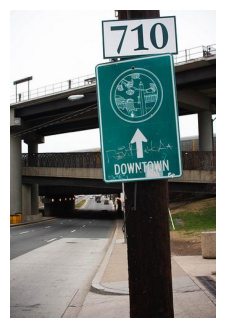

Here is test_50.jpg
Predicted: a stop sign is on the pole . the pole is yellow and black . the sign is red in color . the sign is white . there are wires on the pole . the pole is yellow and black . the sign is on a pole . the pole is yellow and black . the sign is on a pole . the pole is yellow and black . the sign is on a pole . the pole is yellow and black . the sign is on a pole . the pole is yellow and black . the sign is on a pole . the pole is yellow and black . the sign is on a pole . the pole is yellow and black . the sign is on a pole . the pole is yellow and black . the sign is on a pole . the pole is yellow and black . the sign is on a pole . the pole is yellow and black . the sign is on a pole . the pole is yellow and black . the sign is on a pole . the pole is yellow and black . the sign is on a pole . the pole is yellow and black . the sign is on a pole . the pole is yellow and black . the sign is on a pole . the pole is yellow and black . the sign is on a pole . there i

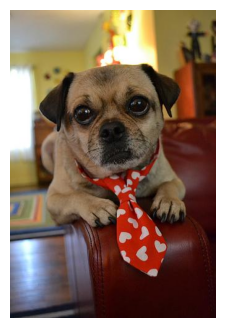

Here is test_100.jpg
Predicted: a woman is standing on the floor . she is wearing a black jacket . the woman is wearing a white shirt . the woman is wearing a red shirt . the woman is wearing a white shirt . the woman is wearing a red shirt . the woman is wearing a white shirt . the woman is wearing a red shirt . the woman is wearing a white shirt . the woman is wearing a red shirt . the woman is wearing a white shirt . the woman is wearing a red shirt . the woman is wearing a white shirt . the woman is wearing a red shirt . the woman is wearing a white shirt . the woman is wearing a red shirt . the woman is wearing a white shirt . the woman is wearing a red shirt . the woman is wearing a white shirt . the woman is wearing a red shirt . the woman is wearing a white shirt . the woman is wearing a red shirt . the woman is wearing a white shirt . the woman is wearing a red shirt . the woman is wearing a white shirt . the woman is wearing a red shirt . the woman is wearing a white shirt . 

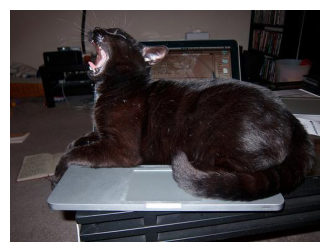

Here is test_150.jpg
Predicted: a cat is laying on a laptop . the cat is gray with black stripes on it . the cat is gray and black with a white collar . there is a black cord on the floor . there is a black cord on the floor . there is a black cord on the table next to the cat . there is a black cord on the table next to the cat . there is a black cord on the table next to the cat . there is a black cord on the table next to the cat . there is a black cord on the table next to the cat . there is a black lamp on the table next to the cat . there is a black cord on the table next to the cat . there is a black cord on the table next to the cat . there is a black cord on the table next to the cat . there is a black cord on the table next to the cat . there is a black cord on the floor . there is a black cord on the floor . there is a black cord on the floor . there is a black cord on the floor . there is a black cord on the floor . there is a black cord on the floor . there is a black cord

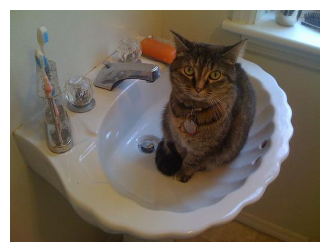

Here is test_200.jpg
Predicted: a cat is laying on a white toilet . the cat is brown and black . the cat has a white collar . the cat has a white collar . the cat has a white collar . the cat has a white collar . the cat has a white collar . the cat has a white collar . the cat has a white collar . the cat has a white collar . the cat has a white collar . the cat has a white collar . the cat has a white collar . the cat has a white collar . the cat has a white collar . the cat has a white collar . the cat has a white collar . the cat has a white collar . the cat has a white collar . the cat has a white collar . the cat has a white collar . the cat has a white collar . the cat has a white collar . the cat has a white collar . the cat has a white collar . the cat has a white collar . the cat has a white collar . the cat has a white collar . the cat has a white collar . the cat has a white collar . the cat has a white collar . the cat has a white collar . the cat has a white collar . the 

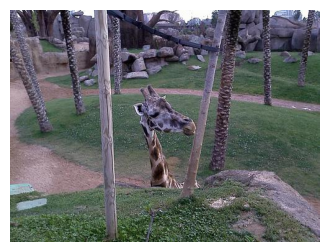

Here is test_250.jpg
Predicted: a giraffe is standing in the middle of a zoo display . it is a sunny day . the giraffe is looking towards the east . there are trees on the ground in front of the fence . there are trees on the ground in front of the fence . there are trees on the ground in front of the fence . there are trees on the ground in front of the fence . there are trees on the ground in front of the fence . there are trees on the ground in front of the fence . there are trees on the ground in front of the fence . there are trees on the ground in front of the fence . there are trees on the ground in front of the fence . there are trees on the ground in front of the fence . there are trees on the ground in front of the fence . there are trees on the ground in front of the fence . there are trees on the ground in front of the fence . there are trees on the ground in front of the fence . there are trees on the ground in front of the fence . there are trees on the ground in front of

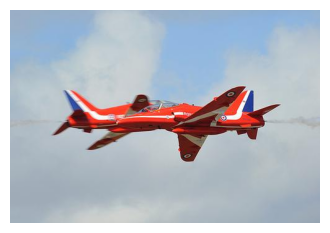

Here is test_300.jpg
Predicted: a large airplane is flying in the sky . there are lots of gray clouds behind the plane . there are lots of gray clouds behind the plane . there is a blue and red stripe on the tail . there is a blue stripe on the tail of the plane . there are also white clouds in the sky . there are lots of gray clouds behind the plane . there are lots of gray clouds behind the plane . there is a blue sky above the plane . there are lots of gray clouds behind the plane . there are also blue and red writing on the plane . there are also white clouds in the sky . the sky is blue and clear . there are no clouds in the sky . there are lots of gray clouds behind the plane . there are also two red lights on the plane . there are also white clouds in the sky . the sky is blue and clear . there are no clouds in the sky . there are lots of gray clouds behind the plane . there are also two red lights on the plane . there are also white clouds in the sky . the sky is blue and clear

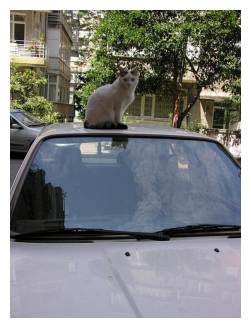

Here is test_350.jpg
Predicted: a large white building with a pointed roof . there is a clock on the side of the building . there is a white building behind the fence . there is a black fence behind the fence . there is a fence around the fence . there is a fence around the fence . there is a fence around the fence . there is a fence around the fence . there is a fence around the fence . there is a fence around the fence . there is a fence around the fence . there is a fence around the fence . there is a fence around the fence . there is a fence around the fence . there is a fence around the fence . there is a fence around the fence . there is a fence around the fence . there is a fence around the fence . there is a fence around the fence . there is a fence around the fence . there is a fence around the fence . there is a fence around the fence . there is a fence around the fence . there is a fence around the fence . there is a fence around the fence . there is a fence around the fence

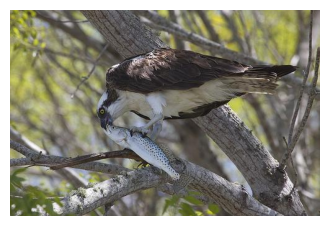

Here is test_400.jpg
Predicted: a bird is standing on a branch . the bird is brown and white . the bird is looking down . the bird is brown and white . the bird is looking down . the bird is brown and has a white beak . the bird is brown and has a white beak . the bird is brown and has a white beak . the bird is brown and has a white beak . the bird is brown and has a white beak . the bird is brown and has a white beak . the bird is brown and has a white beak . the bird is brown and has a long neck . the bird is brown and has a long neck . the bird is brown and has a long neck . the bird is brown and has a long neck . the bird is brown and has a long neck . the bird is brown and has a long neck . the bird is brown and has a long neck . the bird is brown and has a long neck . the bird is brown and has a long neck . the bird is brown and has a long neck . the bird is brown and has a long neck . the bird is brown and has a long neck . the bird is brown and has a long neck . the bird is br

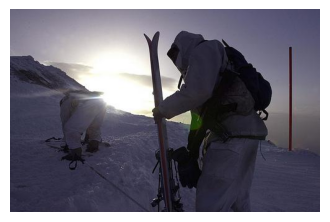

Here is test_450.jpg
Predicted: a person is wearing a black jacket and black pants . they are standing on a snow board . there is a person wearing a black jacket and black pants . there is a person standing in the snow . there is a person with a black jacket and black pants standing on the snow . there is a person with a black jacket standing in front of them . there is a black fence behind the person . there is a person with a black jacket standing in front of them . there is a black fence behind the person . there is a person with a black jacket standing in front of them . there is a black fence behind the person . there is a person with a black jacket standing in front of them . there is a black fence behind the person . there is a person with a black jacket standing in front of them . there is a black fence behind the person . there is a person with a black jacket standing in front of them . there is a black fence behind the person . there is a person with a black jacket standing i

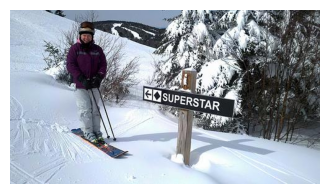

Here is test_500.jpg
Predicted: a person is wearing a red jacket and black pants . there is a person standing on skis next to the person . there are trees behind the person . there are trees on the hill behind the person . there are trees on the hill behind the person . there are trees on the hill . there are trees in the distance . there are also trees on the side of the hill . there are trees on the hill . there are trees in the distance . there is a person with a black jacket and black pants . there is a person in the snow . there is a person in the snow . there is a person in the snow . there is a person with a black jacket and black pants . there is a person in the snow . there is a person in the snow . there is a person in the snow . there is a person with a black jacket and black pants . there is a person in the snow . there is a person in the snow . there is a person in the snow . there is a person with a black jacket and black pants standing on the snow . there is a person wit

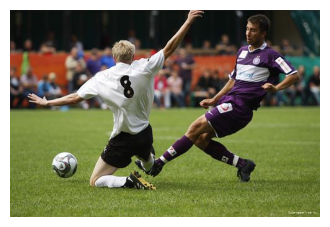

Here is test_550.jpg
Predicted: a man is throwing a frisbee . the frisbee is white in color . there are people in the stands behind the people . the man has a white frisbee . the man has on a white jersey . the man has on white shorts . the man has a white frisbee . the man has on a white jersey . the man has a white frisbee . the man has on a white jersey . the man has a white frisbee . the man has on a white jersey . the man has a white frisbee in his hand . the man has a white frisbee in his hand . the man has a white frisbee in his hand . the man has a white frisbee in his hand . the man has a white frisbee in his hand . the man has a white frisbee in his hand . the man has a white frisbee in his hand . the man has a white frisbee in his hand . the man has a white frisbee in his hand . the man has a white frisbee in his hand . the man has a white frisbee in his hand . the man has a white frisbee in his hand . the man has a white frisbee in his hand . the man has a white frisbee in 

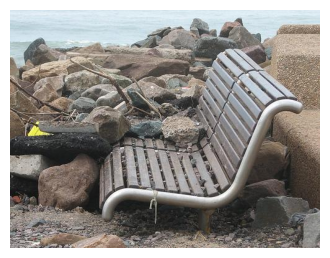

Here is test_600.jpg
Predicted: a woman is sitting on a bench . the bench is made of wood . the bench is made of wood . the bench is made of wood . the bench is made of wood . the bench is made of wood . the bench is made of wood . the bench is made of wood . the bench is made of wood . the bench is made of wood . the bench is made of wood . the bench is made of wood . the bench is made of wood . the bench is made of wood . the bench is made of wood . the bench is made of wood . the bench is made of wood . the bench is made of wood . the bench is made of wood . the bench is made of wood . the bench is made of wood . the bench is made of wood . the bench is made of wood . the bench is made of wood . the bench is made of wood . the bench is made of wood . the bench is made of wood . the bench is made of wood . the bench is made of wood . the bench is made of wood . the bench is made of wood . the bench is made of wood . the bench is made of wood . the bench is made of wood . the bench is

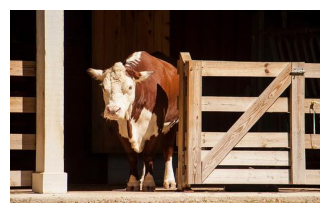

Here is test_650.jpg
Predicted: a woman is standing outside . she is wearing a white tank top and black pants . she is standing in front of a large gray building . there is a large white building behind the woman . the sky above the building is gray and has a large white house on it . there is a large building behind the fence . there is a fence in front of the building . there are also many trees in the background . there is a building behind the fence . there is a pole next to the building . there is a pole next to the building . there is a pole next to the building . there is a pole next to the building . there is a pole next to the building . there is a pole next to the pole . there is a pole next to the pole . there is a pole next to the pole . there is a pole next to the pole . there is a pole next to the pole . there is a pole next to the pole . there is a pole next to the pole . there is a pole next to the pole . there is a pole next to the pole . there is a pole next to the po

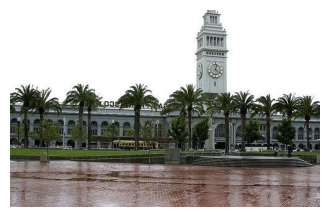

Here is test_700.jpg
Predicted: a building is made of brick and has a clock on it . the clock has roman numerals on it . there is a clock on the building . there is a clock on the building . there is a clock on the building . there is a clock on the building . there is a clock on the building . there are also many windows on the building . there are also many windows on the building . there are also many windows on the building . there are also many skyscrapers behind the building . there is a clock tower in the building . there is a clock on the building . there is a clock tower in the building . the clock has roman numerals on it . there is a clock tower in the building . the clock face is white . there are people standing on the sidewalk . there is a clock tower in the building . there are also many windows on the building . there are also many skyscrapers . there are also many skyscrapers . there is a clock tower in the building . there is a clock on the building . there is a clock

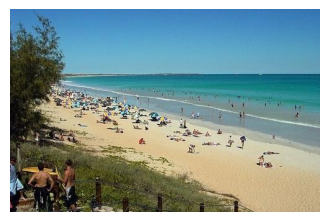

Here is test_750.jpg
Predicted: a large white boat is in the water . there are people standing on the beach . there is a man in a blue shirt standing in front of the water . there is a man in a blue shirt standing in front of the water . there is a man in a blue shirt standing in front of the water . there is a large white building behind the people . there are people standing in the water . there are people standing on the beach in front of the water . there are people standing on the beach in front of the water . there are people standing on the beach in front of the water . there are people standing on the beach in front of the water . there are people standing on the beach in front of the water . there are people sitting on the sand in front of the water . there is a large body of water in the water . there are people standing on the beach in front of the water . there are people sitting on the sand in front of the water . there is a large body of water in the water . there are peo

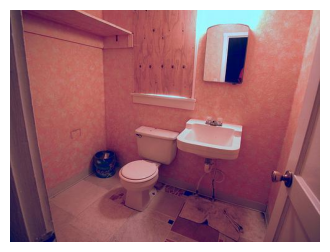

Here is test_800.jpg
Predicted: a white toilet is in a room . there is a white toilet in front of the toilet . there is a white toilet in front of the toilet . there is a white toilet in front of the toilet . there is a white toilet in front of the toilet . there is a white toilet in front of the toilet . there is a white toilet in front of the toilet . there is a white toilet in front of the toilet . there is a white toilet in front of the toilet . there is a white toilet in front of the toilet . there is a white toilet in front of the toilet . there is a white toilet in front of the toilet . there is a white toilet in front of the toilet . there is a white toilet in front of the toilet . there is a white toilet in front of the toilet . there is a white toilet in front of the toilet . there is a white toilet in front of the toilet . there is a white toilet in front of the toilet . there is a white toilet in front of the toilet . there is a white toilet in front of the toilet . there i

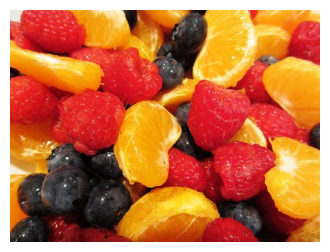

Here is test_850.jpg
Predicted: a white plate of food on a table . there are slices of apples with apples and nuts on top of the apples . there are apples and apples and nuts on top of the apples . there are also apples and apples . there are also apples and apples . there are also apples and apples . there are also apples and apples . there are also apples and apples . there are also apples and apples . there are also apples and apples . there are also apples and apples . there are also apples and apples . there are also apples and apples . there are also apples and apples . there are also apples and apples . there are also potatoes on the apples . there are also pickles on the apples . there are bananas , apples , oranges and a bowl of oranges . the bowl is on a table with a white tablecloth . there is a fork on the table . there are also two jars of red apples . there is a silver fork on the plate . there are also pickles on the table . there are also apples and apples . there are a

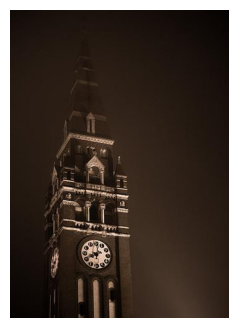

Here is test_900.jpg
Predicted: a large building is standing behind a tall brick building . there is a clock on the building . there is a clock on the building . there is a clock on the building . there is a clock on the building . there is a clock on the building . there is a clock on the building . there is a clock on the building . there is a clock on the building . there is a clock on the building . there is a clock on the building . there is a clock on the building . there is a clock on the building . there is a clock on the building . there is a clock on the building . there is a clock on the building . there is a clock on the building . there is a clock on the building . there is a clock on the building . there is a clock on the building . there is a clock on the building . there is a clock on the building . there is a clock on the building . there is a clock on the building . there is a clock on the building . there is a clock on the building . there is a clock on the building 

In [26]:
predicted_captions = []
actual_captions = []

f = open("/kaggle/working/output.txt", "w")


for i in range(928):
    image_path = f'/kaggle/input/custom_captions_dataset/test/test_{i+1}.jpg'
    image = Image.open(image_path).convert('RGB')
    predicted_caption = inference(encoder, decoder, image, transform, device, tokens, index_to_word, caption_size)
    predicted_captions.append(predicted_caption)

    actual_caption = str(test_cap['caption'][i])
    actual_captions.append(actual_caption)

    if (i+1) % 50 == 0:
        # Display the image
        plt.figure(figsize=(4, 4))
        plt.imshow(image)
        plt.axis('off')

        # Print the predicted caption below the image
        plt.show()
        print(f"Here is test_{i+1}.jpg")
        print(f"Predicted: {predicted_caption}\n")
        print("Actual: ", actual_caption)
        print("\n")
        
    f.write(f"{i+1} Predicted:{predicted_caption}\n")
f.close()    

# predicted_captions_dict = {i: [nltk.tokenize.word_tokenize(predicted) for predicted in predicted_captions] for i in range(len(predicted_captions))}
# actual_captions_dict = {i: [nltk.tokenize.word_tokenize(actual) for actual in actual_captions] for i in range(len(actual_captions))}

# # Compute CIDEr score
# cider_scores = compute_cider(actual_captions_dict, predicted_captions_dict)
# print("Overall CIDEr score:", cider_scores)

In [27]:
# from pycocoevalcap.cider.cider import Cider

# def compute_cider(reference_captions, generated_captions):
#     # Initialize Cider scorer
#     cider_scorer = Cider()

#     # Tokenize reference and generated captions
#     reference_tokens = {i: [ref] for i, ref in enumerate(reference_captions)}
#     generated_tokens = {i: [gen] for i, gen in enumerate(generated_captions)}

#     # Compute CIDEr score
#     (score, scores) = cider_scorer.compute_score(reference_tokens, generated_tokens)

#     return score


# Printing Scores

In [28]:
# Compute BLEU scores
bleu_scores = [sentence_bleu(predicted, actual, weights=[1]) for predicted, actual in zip(predicted_captions, actual_captions)]
overall_bleu = sum(bleu_scores) / len(bleu_scores)
print("Overall BLEU score:", overall_bleu)

# Compute ROUGE scores
rouge_scores = [compute_rouge(predicted, actual) for predicted, actual in zip(predicted_captions, actual_captions)]
overall_rouge = sum(rouge_scores) / len(rouge_scores)
print("Overall ROUGE score:", overall_rouge)

# # Compute CIDER score
# cider_scores = [compute_cider(actual ,predicted) for predicted,actual in zip(predicted_captions, actual_captions)]
# overall_cider = sum(cider_scores) / len(cider_scores)
# print("Overall CIDER score:", overall_cider)

Overall BLEU score: 0.07842462762853006
Overall ROUGE score: 0.14932613825467883
